# Extended kNN & SVM Prediction Project

*Shaney Sze, Feburary 19, 2023*

*Data Science for Decision Making, Barcelona School of Economics 2023*

This notebook is organized as follows:

1. [Data Preparation](#1---data-preparation)
2. [Feature Selection](#2---feature-selection)
3. [Pipelines](#3---pipelines)

    a. [kNN Pipeline](#3a---knn-pipeline)
    
    b. [SVM Pipeline](#3b---svm-pipeline)
4. [Appendix](#appendix)


### 0 - Imports

In [1]:
import datetime
import time
import pandas as pd
import seaborn as sns
import numpy as np
from numpy import random

from matplotlib import pyplot as plt
from category_encoders import TargetEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn import preprocessing
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

sns.set_theme(style="whitegrid")

### 1 - Data Preparation

Read in datasets.

In [2]:
data = pd.read_csv('mimic_data/mimic_train.csv')
data_test = pd.read_csv('mimic_data/mimic_test_death.csv')
data_diag = pd.read_csv('mimic_data/extra_data/MIMIC_diagnoses.csv')
data_diag.columns = [x.lower() for x in data_diag.columns]

In [3]:
# dropping LOS (Length of Stay) since it is another target variable that we are not concern of in this case
data = data.drop('LOS', axis=1)
data.head(5)

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,2178-02-06 10:35:00,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,2129-02-12 22:34:00,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,2125-11-17 23:04:00,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,2131-01-26 08:00:00,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,...,2146-05-04 02:02:00,-50271.76602,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU


Define categorical and numerical features.

In [4]:
cat_feats = ['GENDER', 'ADMISSION_TYPE',
       'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY',
       'FIRST_CAREUNIT']

num_feats = ['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean']


*Data Preparation.* Here, I create functions for cleaning time strings and getting the age, visits variables. For age, I infer by using the admission time, DOB, and Diff to adjust for the actual age.  For visits, I simply count how many times a subject_id appears in the dataframe. I also create mappings for ethnicity here: if the `ETHNICITY` column contains a certain string denoting the umbrella ethnicity, I set it as that, else, I set it as `OTHER`.

In [5]:
# helper functions
def get_year(date_time_str):
    return datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S').year

def get_month(date_time_str):
    return datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S').month

def get_day(date_time_str):
    return datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S').day

def get_dt(date_time_str):
    return datetime.datetime.strptime(date_time_str, "%Y-%m-%d %H:%M:%S")

def get_age(df):
    df['ADMITTIME'] = (df["ADMITTIME"].apply(get_dt) + df["Diff"].apply(lambda x: datetime.timedelta(x))).apply(lambda x: x.date())
    df['DOB'] = (df["DOB"].apply(get_dt) + df["Diff"].apply(lambda x: datetime.timedelta(x))).apply(lambda x: x.date())
    df['AGE'] = (df['ADMITTIME'] - df['DOB']).apply(lambda x: x.days//365)
    return df

def get_visits(df):
    visits = pd.DataFrame(df.subject_id.value_counts().reset_index())
    visits.columns = ['subject_id', 'VISITS']
    df = df.merge(visits, on='subject_id', how='left')
    return df

def get_ethnicity(df):
    df.loc[df['ETHNICITY'].str.contains('WHITE'), 'ETHNICITY'] = 'WHITE'
    df.loc[df['ETHNICITY'].str.contains('BLACK'), 'ETHNICITY'] = 'BLACK'
    df.loc[df['ETHNICITY'].str.contains('AFRICAN'), 'ETHNICITY'] = 'BLACK'
    df.loc[df['ETHNICITY'].str.contains('HISPANIC'), 'ETHNICITY'] = 'LATINO'
    df.loc[df['ETHNICITY'].str.contains('LATINO'), 'ETHNICITY'] = 'LATINO'
    df.loc[df['ETHNICITY'].str.contains('ASIAN'), 'ETHNICITY'] = 'ASIAN'
    df.loc[~df['ETHNICITY'].isin(['WHITE', 'BLACK', 'LATINO', 'ASIAN']), 'ETHNICITY'] = 'OTHER'
    return df


In [6]:
data = get_age(data)
data_test = get_age(data_test)

data = get_visits(data)
data_test = get_visits(data_test)

data = get_ethnicity(data)
data_test = get_ethnicity(data_test)

*Handle Outlier: Age.* Notice there is a relatively many occurances where outliers exist. In the `mimic-code` [github](https://github.com/MIT-LCP/mimic-code/issues/637), it is stated "Dates of birth for patients aged over 89 were shifted to obscure their true age and comply with HIPAA regulations: these patients appear in the database with ages of over 300 years". In these cases, we can only know they are older than 89, but no more information of the exact age like 92, 93. I will handle this by generating and assigning a random number from `89` to `99` for these occurances.



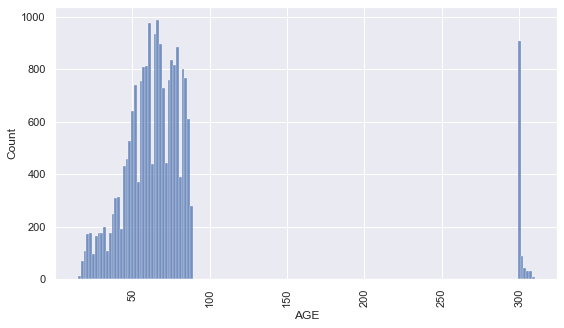

In [7]:
# pre outlier handling
sns.set(rc={'figure.figsize':(9, 5)})

sns.histplot(data=data, x='AGE', palette='muted')

plt.xticks(rotation=90);

In [8]:
# assign random old age
data['AGE'] = np.where(data['AGE'] > 100 , random.randint(89, 99), data['AGE'])

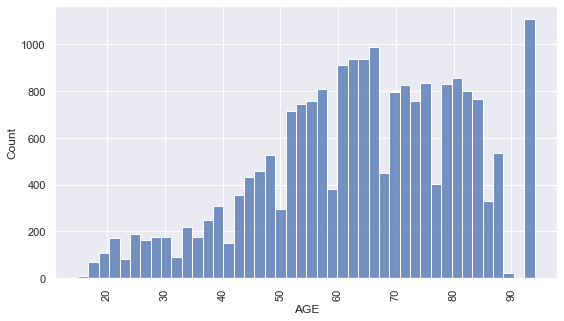

In [9]:
# post outlier handling
sns.set(rc={'figure.figsize':(9, 5)})

sns.histplot(data=data, x='AGE', palette='muted')

plt.xticks(rotation=90);

*Diagnosis per patient.* Get diagnosis count for each subject. In the figure below, I show that patients with about 14 to 21 diagnoses are more likely to die. Patients with 39 diagnoses are also more likely to die. This information is then merged to the training dataframe as numerical values under `seq_num`.

In [10]:
# get the number of diagnosis
data_diag_count = data_diag[['hadm_id', 'seq_num']].groupby(['hadm_id'], sort = False).max()

# merge that data with original train and test datasets
data = data.merge(data_diag_count, on = ['hadm_id'], how = 'left')
data_test = data_test.merge(data_diag_count, on = ['hadm_id'], how = 'left')


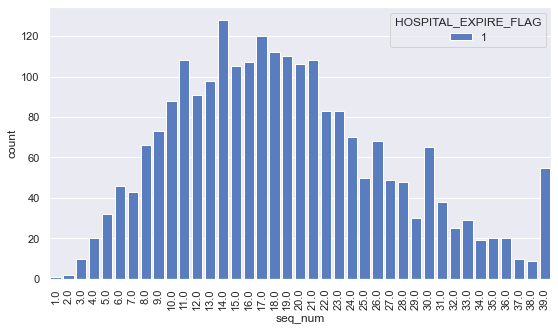

In [11]:
sns.set(rc={'figure.figsize':(9, 5)})

sns.countplot(data=data[data.HOSPITAL_EXPIRE_FLAG==1], x='seq_num', hue='HOSPITAL_EXPIRE_FLAG', palette='muted');

plt.xticks(rotation=90);

*ICD-9 Codes.* ICD-9 codes are grouped by the first 3 digits (see [Wikipedia](https://en.wikipedia.org/wiki/List_of_ICD-9_codes)).  For example, icd9_code `53240` belongs to subgroup `520–579: diseases of the digestive system`, and code `25000` belongs to subgroup `240–279: endocrine, nutritional and metabolic diseases, and immunity disorders`, and so on. Since the original dataset has almost 7000 unique `icd9_code`, grouping them by these subgroups can contain them more effectively. Here, I parse the first 3 digits of the `ICD9_diagnosis` and create a `icd9_subgroup` column.

Note: Some codes begin with `E` or `V` instead of digits, as well as some with leading zeros. For now, I set them as some arbitary value to handle later on.

In [12]:
# Filter out E and V codes since processing will be done on the numeric first 3 values
data_diag['icd9_subgroup'] = data_diag['icd9_code'][~data_diag['icd9_code'].str.contains("[a-zA-Z]").fillna(False)]
data_diag['icd9_subgroup'].fillna(value='-99999', inplace=True)

# slice strings
data_diag['icd9_subgroup'] = data_diag['icd9_subgroup'].str.slice(start=0, stop=3, step=1)
data_diag['icd9_subgroup'] = data_diag['icd9_subgroup'].astype(int)

data_diag.head(15)

,subject_id,hadm_id,seq_num,icd9_code,icd9_subgroup
0,256,108811,1.0,53240,532
1,256,108811,2.0,41071,410
2,256,108811,3.0,53560,535
3,256,108811,4.0,40390,403
4,256,108811,5.0,5859,585
5,256,108811,6.0,04186,41
6,256,108811,7.0,41401,414
7,256,108811,8.0,2724,272
8,256,108811,9.0,496,496
9,256,108811,10.0,42731,427


In [13]:
# ICD-9 top-level ranges
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390), 
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000),(1000, 2000), (-99999,-1)]

# grouping names
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin', 
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'symptoms',
             16: 'injury', 17: 'misc', 18: 'E and V'}

# re-code in terms of integer
for num, cat_range in enumerate(icd9_ranges):
    range_begin = cat_range[0]
    range_end = cat_range[1]
    data_diag['icd9_subgroup'] = np.where(data_diag['icd9_subgroup'].between(range_begin, range_end), num, data_diag['icd9_subgroup'])

data_diag.head(15)

,subject_id,hadm_id,seq_num,icd9_code,icd9_subgroup
0,256,108811,1.0,53240,8
1,256,108811,2.0,41071,6
2,256,108811,3.0,53560,8
3,256,108811,4.0,40390,6
4,256,108811,5.0,5859,9
5,256,108811,6.0,04186,0
6,256,108811,7.0,41401,6
7,256,108811,8.0,2724,2
8,256,108811,9.0,496,7
9,256,108811,10.0,42731,6


In [14]:
# merge subgroup data in main dataframe, match on 'seq_num' so we know which icd9_subgroup diagnosis the patient died from
data = data.merge(data_diag[['hadm_id','seq_num','icd9_subgroup']], on = ['hadm_id','seq_num'], how = 'left')
data_test = data_test.merge(data_diag[['hadm_id','seq_num','icd9_subgroup']], on = ['hadm_id','seq_num'], how = 'left')


*Death rate for each diagnosis subgroup.* For both diagnosis code diagnosis subgroup, I generate features using their max, mean, and median value respectively. The idea here is that diagnoses with a higher maximum death rate will usually end up killing the patient, and the mean and median values can help the regression's accuracy. I then merged everything back to both train and test sets.

In [15]:
# merge the diagnoses data with the hospital expire flag data
data_diagnoses_all = data_diag.merge(data[['hadm_id', 'HOSPITAL_EXPIRE_FLAG']], on=['hadm_id'], how='left')

# group diagnoses by ICD-9 code and subgroup to count how many patients died from each code/subgroup
most_killed_diag_code = data_diagnoses_all.groupby(['HOSPITAL_EXPIRE_FLAG', 'icd9_code']).size().reset_index(name='counts')
most_killed_diag_subgroup = data_diagnoses_all.groupby(['HOSPITAL_EXPIRE_FLAG', 'icd9_subgroup']).size().reset_index(name='counts')

# pivot the data to put the number of deaths for each code/subgroup in separate columns
most_killed_diag_code = most_killed_diag_code.pivot(index='icd9_code', columns='HOSPITAL_EXPIRE_FLAG', values='counts')
most_killed_diag_subgroup = most_killed_diag_subgroup.pivot(index='icd9_subgroup', columns='HOSPITAL_EXPIRE_FLAG', values='counts')

# fill missing values with zeros
most_killed_diag_code.fillna(0, inplace=True)
most_killed_diag_subgroup.fillna(0, inplace=True)

# calculate death rates for each ICD-9 code and subgroup
most_killed_diag_code['icd9_code_death_rate'] = (most_killed_diag_code[1] / most_killed_diag_code.sum(axis=1)).fillna(0)
most_killed_diag_subgroup['icd9_subgroup_death_rate'] = (most_killed_diag_subgroup[1] / most_killed_diag_subgroup.sum(axis=1)).fillna(0)

# reset index to make the code/subgroup columns into regular columns
most_killed_diag_code.reset_index(inplace=True)
most_killed_diag_subgroup.reset_index(inplace=True)

# merge death rates with diagnoses data by code/subgroup
data_diagnoses_all_code = data_diagnoses_all.merge(most_killed_diag_code[['icd9_code', 'icd9_code_death_rate']], on='icd9_code', how='left')
data_diagnoses_all_subgroup = data_diagnoses_all.merge(most_killed_diag_subgroup[['icd9_subgroup', 'icd9_subgroup_death_rate']], on='icd9_subgroup', how='left')

# calculate the maximum, mean, and median death rates per patient for each code/subgroup
data_diagnoses_all_code['icd9_code_death_max'] = data_diagnoses_all_code.groupby('hadm_id')['icd9_code_death_rate'].transform('max')
data_diagnoses_all_code['icd9_code_death_mean'] = data_diagnoses_all_code.groupby('hadm_id')['icd9_code_death_rate'].transform('mean')
data_diagnoses_all_code['icd9_code_death_median'] = data_diagnoses_all_code.groupby('hadm_id')['icd9_code_death_rate'].transform('median')

data_diagnoses_all_subgroup['icd9_subgroup_death_max'] = data_diagnoses_all_subgroup.groupby('hadm_id')['icd9_subgroup_death_rate'].transform('max')
data_diagnoses_all_subgroup['icd9_subgroup_death_mean'] = data_diagnoses_all_subgroup.groupby('hadm_id')['icd9_subgroup_death_rate'].transform('mean')
data_diagnoses_all_subgroup['icd9_subgroup_death_median'] = data_diagnoses_all_subgroup.groupby('hadm_id')['icd9_subgroup_death_rate'].transform('median')

# drop duplicate rows and select the relevant columns
data_death_rates_code = data_diagnoses_all_code.drop_duplicates('hadm_id')[['hadm_id', 'icd9_code_death_max', 'icd9_code_death_mean', 'icd9_code_death_median']]
data_death_rates_subgroup = data_diagnoses_all_subgroup.drop_duplicates('hadm_id')[['hadm_id', 'icd9_subgroup_death_max', 'icd9_subgroup_death_mean', 'icd9_subgroup_death_median']]


In [16]:
# merge into main data
data = data.merge(data_death_rates_code, on = ['hadm_id'], how = 'left')
data = data.merge(data_death_rates_subgroup, on = ['hadm_id'], how = 'left')

data_test = data_test.merge(data_death_rates_code, on = ['hadm_id'], how = 'left')
data_test = data_test.merge(data_death_rates_subgroup, on = ['hadm_id'], how = 'left')


*Most Common Diagnosis.* I want to know which ones rank the highest when it comes to patient death. Then, I use them as dummies to incorporate into the model. However, I only want to keep the most relevant diagnosis - the ones that contribute to more deaths. The output dataframe here includes 36 dummy columns of the most common diagnoses, grouped by the patient id.

In [17]:
# group diagnoses by icd9 code and hospital expire flag to count occurrences
diag = data_diagnoses_all.groupby(['icd9_code', 'HOSPITAL_EXPIRE_FLAG']).size().unstack(fill_value=0)
alive, death = diag[0], diag[1]

# dataframe with count information for most common diagnoses, exclude those with fewer than 200 deceased patients
common = pd.DataFrame({'icd9_code': death.index, 'counts_x': death, 'counts_y': alive})
common = common[common['counts_x'] > 200].reset_index(drop=True)

# select rows from comorbidities data with most common diagnoses and create dummies for those diagnoses
common_diag = pd.get_dummies(data_diagnoses_all[data_diagnoses_all['icd9_code'].isin(common['icd9_code'])], columns=['icd9_code'])

# group by hospital admission id, get the maximum value for each diagnosis to create binary indicator
common_diag = common_diag.groupby('hadm_id').max().astype(bool)
common_diag = data_diagnoses_all[data_diagnoses_all['icd9_code'].isin(list(common['icd9_code']))]
common_diag = common_diag.drop(['seq_num', 'HOSPITAL_EXPIRE_FLAG'], axis=1)

# Group the data by `hadm_id` and `icd9_code` and count the occurrences
common_diag_counts = common_diag.groupby(['hadm_id', 'icd9_code']).size().reset_index(name='count')

# Pivot the data to create a binary matrix where each row corresponds to a `hadm_id` and each column corresponds to an `icd9_code`
common_diag_p = common_diag_counts.pivot(index='hadm_id', columns='icd9_code', values='count').fillna(0)


In [18]:
# Merge into main data set
data = data.merge(common_diag_p, on = ['hadm_id'], how = 'left')
data_test = data_test.merge(common_diag_p, on = ['hadm_id'], how = 'left')


Some extra cleaning.

In [19]:
# data = data.drop(['subject_id_y', 'seq_num_y', 'seq_num_x'], axis=1)
data_merged_diag = data.drop_duplicates(['hadm_id', 'icustay_id', 'HeartRate_Max'], keep='last')
data_merged_diag = data_merged_diag.rename({'subject_id_x':'subject_id'}, axis=1)

# data_test = data_test.drop(['subject_id_y', 'seq_num_y', 'seq_num_x'], axis=1)
data_merged_diag_test = data_test.drop_duplicates(['hadm_id', 'icustay_id'], keep='last')
data_merged_diag_test = data_merged_diag_test.rename({'subject_id_x':'subject_id'}, axis=1)

### 2 - Feature Selection

*Feature Selection.* There are many ways to select features. Below, I first look at the correlation heatmap and select the features that are most highly correlated to our target variable, `HOSPITAL_EXPIRE_FLAG`.  Since we engineered the `icd9_subgroup` feature, we can drop other diagnosis-related features to prevent duplicated information.

In [20]:
# first, remove unwanted catagorial features
drop_feats = ['DOB', 'ADMITTIME', 'DIAGNOSIS', 'Diff', 'ICD9_diagnosis']
data_merged_diag = data_merged_diag.drop(drop_feats, axis=1)
data_merged_diag_test = data_merged_diag_test.drop(drop_feats, axis=1)

*Encoding.* Before selecting the feature, I encode the categorical variables ('GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'FIRST_CAREUNIT') using `TargetEncoder()`, which replaces a categorical variable with the mean of the target variable. Smoothing can help deal with cases where very observations had a certain disease.

In [21]:
# encode and make them all numeric
encoder = TargetEncoder(smoothing=1).fit_transform(data_merged_diag[cat_feats],data_merged_diag['HOSPITAL_EXPIRE_FLAG'])

data_merged_diag[cat_feats] = encoder
data_merged_diag_test[cat_feats] = encoder

Here I visualize the correlations among features.

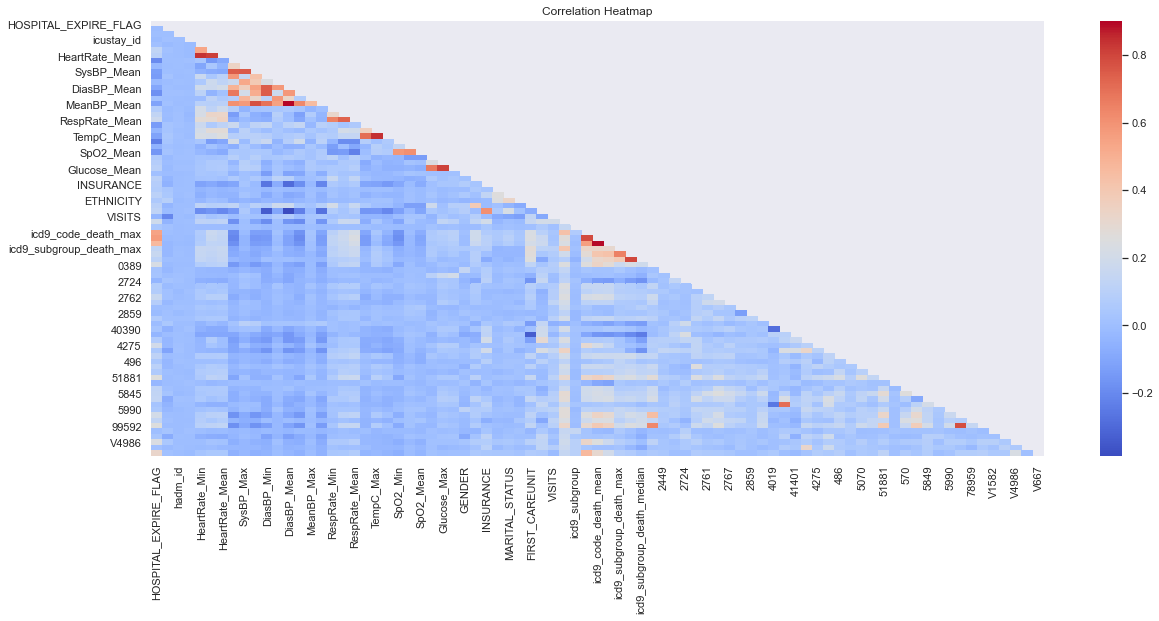

In [22]:
plt.figure(figsize = (20, 8))
mask = np.triu(np.ones_like(data_merged_diag.corr(numeric_only=True), dtype=bool))
heatmap = sns.heatmap(data_merged_diag.corr(),
                      mask=mask,
                      annot=False,
                      cmap='coolwarm')
heatmap.set_title('Correlation Heatmap');

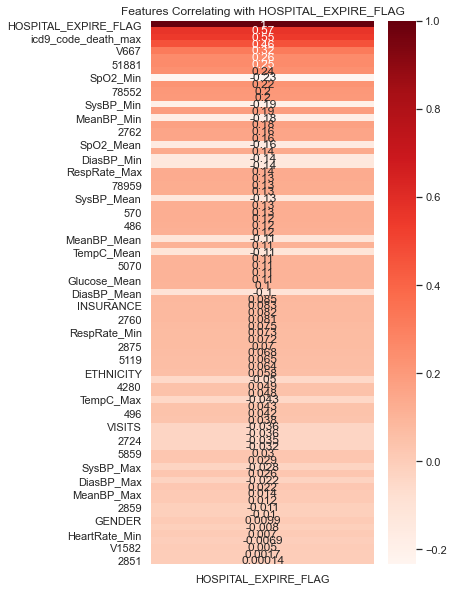

In [23]:
top_features = data_merged_diag.corr(numeric_only=True)[['HOSPITAL_EXPIRE_FLAG']].sort_values(by='HOSPITAL_EXPIRE_FLAG', key = abs, ascending=False)
plt.figure(figsize=(5, 10))
heatmap = sns.heatmap(top_features,
                      annot=True,
                      cmap='Reds')
heatmap.set_title('Features Correlating with HOSPITAL_EXPIRE_FLAG');
plt.yticks(rotation=0);

Now, we actually get to pick the features for our model. Here, I set the correlation threshold filter to 5%.  If a feature does not correlate with our target variables at at least the 5% mark, it will be dropped.  I chose 5% since it performed the best for both kNN and SVM models. 

In [24]:
# set correlation threshold
corr_threshold = 0.05

# sort absolute correlation of all features
corr = data_merged_diag.corr(numeric_only=True)[['HOSPITAL_EXPIRE_FLAG']].sort_values(by='HOSPITAL_EXPIRE_FLAG', key = abs, ascending=False)

# get index names of highly correlated features
top_features = corr.index[corr['HOSPITAL_EXPIRE_FLAG'] > corr_threshold].tolist()

# filter dataset to our top correlated features
data_merged_diag_downsampled = data_merged_diag[top_features]
data_merged_diag_test_downsampled = data_merged_diag_test[top_features[1:]]

### 3 - Pipelines

*Reweighting function.* To control the bias from our probabilities, we have to take account for the fact that they were based on a biased sample.  The function below is used on the probabilities generated using the kNN or SVM model to tackle class imbalance.

In [25]:
# helper function for reweighting
def reweight(pi, q1=0.5, r1=0.5):
    r0 = 1 - r1
    q0 = 1 - q1
    tot = pi*(q1/r1)+(1-pi)*(q0/r0)
    w = pi*(q1/r1)
    w /= tot
    return w

# prepare dataframe for model fitting
y = data_merged_diag_downsampled["HOSPITAL_EXPIRE_FLAG"]
X = data_merged_diag_downsampled.drop(['HOSPITAL_EXPIRE_FLAG'], axis=1)
X_test = data_merged_diag_test_downsampled

# reweight outsample model
q1 = ((y+1)/2).sum()/len(y)
r1 = 0.5


Pipelines: kNN + SVM.

Here, I use the `imbPipeline` as it allows me to leverage the `SMOTE` technique for imbalanced classes:


*Imputation*

- `KNNImputer` is used to impute missing values with the k-nearest neighbors algorithm. 
    - As for why the `KNNImputer` performed well, it's likely because it can handle missing values in a way that preserves the underlying structure of the data. KNN imputation works by replacing missing values with values from the k-nearest neighbors of each missing value. This means that the imputed values are similar to the original values in the dataset, which can help preserve the distribution and correlations of the features. The `weights='distance'` parameter setting further emphasizes the importance of closer neighbors in the imputation, which can improve its accuracy. Additionally, since the `add_indicator` parameter is set to `False`, no additional indicator variables are added to the dataset, which can help reduce the dimensionality of the data and potentially improve the performance of the model.
- `StandardScaler` is used to standardize the data. Other scalers tested include `RobustScaler` and `MinMaxScaler`, which did not perform as well.
- For kNN, `SMOTE` is used to oversample the minority class by generating synthetic samples.
- I specify `KNeighborsClassifier` to be our classifier here with weights as `distance`, this weight points by the inverse of their distance.

*Hypertuning*

The hyperparameters for the kNN and SVM are varied in grid search after multiple fittings and scorings.


*k-fold*

The code uses stratified k-fold cross-validationp to reserve the class distribution of the target variable when splitting the data.

*Grid Search*
Using GridSearchCV, I tune the hyperparameters for the linear kernel to find the best scoring
combination. 

An alternative would be to use `HalvingGridSearchCV`. The `HalvingGridSearchCV` class is used for grid search with halving.  `HalvingGridSearchCV` is a more efficient version of `GridSearchCV`. It uses a divide-and-conquer approach that repeatedly halves the parameter space until a sufficient number of resources has been allocated to the best hyperparameter set, which results in faster computation times and lower resource consumption compared to `GridSearchCV`. This makes `HalvingGridSearchCV` more suitable for large datasets and complex models.

In earlier iterations, I tested the non-linear kernels on a lower dimension dataframe since non-linear kernels have several magnitudes higher of a runtime. The non-linear kernels did not increase the model's score that much. The cost and benefit for running non-linear kernels on a high dimensional space, in this case, did not prove to be worth it. Thus, in my final models I am only running the linear kernel with several parameters for hypertuning.

*Best model*

The best hyperparameters are printed along with their corresponding cross-validation score using the best_params_ and best_score_ attributes of the `HalvingGridSearchCV` object. The results are then reweighted.

#### 3a - kNN Pipeline

In [27]:
# kNN pipeline
pipe_knn = imbPipeline([ 
                ('imputer', KNNImputer(missing_values=np.nan,
                                       weights = 'distance',
                                       add_indicator = False)),
                ('preprocessing', StandardScaler()),
                ('sampling', SMOTE()),
                ('classifier', KNeighborsClassifier(weights = 'distance',
                                                    metric = 'minkowski'))])

# Grid
params_knn = [
            {
                'imputer__n_neighbors':[100, 150, 200]
            },
            {
                'classifier__n_neighbors':[250, 275, 300],
                'classifier__p':[1, 2]
            }]

kfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

#Run grid search
# grid_knn = HalvingGridSearchCV(pipe_knn, param_grid = params_knn, scoring = 'roc_auc', cv = kfolds, verbose = 3, min_resources = 'exhaust', factor = 3)
grid_knn = GridSearchCV(pipe_knn, param_grid = params_knn, scoring = 'roc_auc', cv = kfolds, verbose = 3)

#Fit model
grid_knn.fit(X, y)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END ..........imputer__n_neighbors=100;, score=0.884 total time=  48.3s
[CV 2/3] END ..........imputer__n_neighbors=100;, score=0.889 total time=  38.8s
[CV 3/3] END ..........imputer__n_neighbors=100;, score=0.892 total time=  34.5s
[CV 1/3] END ..........imputer__n_neighbors=150;, score=0.886 total time=  24.1s
[CV 2/3] END ..........imputer__n_neighbors=150;, score=0.888 total time=  29.3s
[CV 3/3] END ..........imputer__n_neighbors=150;, score=0.891 total time=  23.6s
[CV 1/3] END ..........imputer__n_neighbors=200;, score=0.890 total time=  24.2s
[CV 2/3] END ..........imputer__n_neighbors=200;, score=0.889 total time=  25.2s
[CV 3/3] END ..........imputer__n_neighbors=200;, score=0.890 total time=  24.5s
[CV 1/3] END classifier__n_neighbors=250, classifier__p=1;, score=0.933 total time=  27.3s
[CV 2/3] END classifier__n_neighbors=250, classifier__p=1;, score=0.935 total time=  34.0s
[CV 3/3] END classifier__n_ne

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('imputer',
                                        KNNImputer(weights='distance')),
                                       ('preprocessing', StandardScaler()),
                                       ('sampling', SMOTE()),
                                       ('classifier',
                                        KNeighborsClassifier(weights='distance'))]),
             param_grid=[{'imputer__n_neighbors': [100, 150, 200]},
                         {'classifier__n_neighbors': [250, 275, 300],
                          'classifier__p': [1, 2]}],
             scoring='roc_auc', verbose=3)

In [28]:
print("Best parameter (CV score=%0.3f):" % grid_knn.best_score_)
print(grid_knn.best_params_)

Best parameter (CV score=0.934):
{'classifier__n_neighbors': 300, 'classifier__p': 1}


kNN probabilities are weighed here prior to submission.

In [29]:
y_pred_knn = grid_knn.predict_proba(X_test)
y_pred_knn = reweight(y_pred_knn)

# generate dataset for kaggle submission
knn_submit = pd.DataFrame({
    "icustay_id": data_test["icustay_id"].drop_duplicates(),
    "HOSPITAL_EXPIRE_FLAG": y_pred_knn[:,1] # does it work here?
    })

knn_submit['icustay_id'] = knn_submit['icustay_id'].apply(np.int64)

knn_submit.to_csv('out/sze_knn_{}_{}_{}.csv'.format(time.strftime("%y%m%d_%H%M"), corr_threshold, int(grid_knn.best_score_ * 1e4)), index=False)


#### 3b - SVM Pipeline

In [30]:
# svm pipeline
pipe_svm = imbPipeline([ 
                ('imputer', KNNImputer(missing_values=np.nan,
                                       weights = 'distance',
                                       add_indicator = False)),
                ('preprocessing', StandardScaler()), # robust?
                ('classifier', SVC(kernel='linear',
                                   class_weight='balanced',
                                   probability=True))]) # try adding/removing BaggingClassifier

# Grid
params_svm = [
            {
                'imputer__n_neighbors':[125, 165, 205]
            },
            {
                'classifier__C':[0.5, 0.8, 1], # performance plateaus above 1
                'classifier__gamma':['scale', 0.01, 1]
            }]

# kfolds
kfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

#Run grid search
# grid_svm = HalvingGridSearchCV(pipe_svm, param_grid = params_svm, scoring = 'roc_auc', cv = kfolds, verbose = 3, min_resources = 'exhaust', factor = 3)
grid_svm = GridSearchCV(pipe_svm, param_grid = params_svm, scoring = 'roc_auc', cv = kfolds, verbose = 3)

#Fit model
grid_svm.fit(X, y)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END ..........imputer__n_neighbors=125;, score=0.947 total time= 1.6min
[CV 2/3] END ..........imputer__n_neighbors=125;, score=0.952 total time= 1.6min
[CV 3/3] END ..........imputer__n_neighbors=125;, score=0.951 total time= 1.6min
[CV 1/3] END ..........imputer__n_neighbors=165;, score=0.947 total time= 1.6min
[CV 2/3] END ..........imputer__n_neighbors=165;, score=0.952 total time= 1.7min
[CV 3/3] END ..........imputer__n_neighbors=165;, score=0.951 total time= 1.6min
[CV 1/3] END ..........imputer__n_neighbors=205;, score=0.947 total time= 1.6min
[CV 2/3] END ..........imputer__n_neighbors=205;, score=0.952 total time= 1.9min
[CV 3/3] END ..........imputer__n_neighbors=205;, score=0.951 total time= 2.0min
[CV 1/3] END classifier__C=0.5, classifier__gamma=scale;, score=0.947 total time= 1.6min
[CV 2/3] END classifier__C=0.5, classifier__gamma=scale;, score=0.952 total time= 1.7min
[CV 3/3] END classifier__C=0.5, 

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('imputer',
                                        KNNImputer(weights='distance')),
                                       ('preprocessing', StandardScaler()),
                                       ('classifier',
                                        SVC(class_weight='balanced',
                                            kernel='linear',
                                            probability=True))]),
             param_grid=[{'imputer__n_neighbors': [125, 165, 205]},
                         {'classifier__C': [0.5, 0.8, 1],
                          'classifier__gamma': ['scale', 0.01, 1]}],
             scoring='roc_auc', verbose=3)

In [31]:
# print results
print("Best parameter (CV score=%0.3f):" % grid_svm.best_score_)
print(grid_svm.best_params_)

Best parameter (CV score=0.950):
{'classifier__C': 1, 'classifier__gamma': 'scale'}


SVM probabilities are weighed here prior to submission.

In [32]:
# predict test results
y_pred_svm = grid_svm.predict_proba(X_test)
y_pred_svm = reweight(y_pred_svm)

# generate dataset for kaggle submission
svm_submit = pd.DataFrame({
    "icustay_id": data_test["icustay_id"].drop_duplicates(),
    "HOSPITAL_EXPIRE_FLAG": y_pred_svm[:,1] 
    })

svm_submit['icustay_id'] = svm_submit['icustay_id'].apply(np.int64)

svm_submit.to_csv('out/sze_svm_{}_{}_{}.csv'.format(time.strftime("%y%m%d_%H%M"), corr_threshold, int(grid_svm.best_score_ * 1e4)), index=False)

### Appendix

*Appendix: Naive SVC Model.* Here's the score we get if we simply use default parameters for SVC with no hyperparameter tuning. 

In [33]:
knn_imputer = KNNImputer()
X_imputed_df = pd.DataFrame(knn_imputer.fit_transform(X), columns=X.columns)
scaler = preprocessing.StandardScaler().fit(X_imputed_df[X_imputed_df.columns])
df_scaled = scaler.transform(X_imputed_df[X_imputed_df.columns])
X_imputed_df[X_imputed_df.columns] = pd.DataFrame(df_scaled, columns=X_imputed_df[X_imputed_df.columns].columns)

In [34]:
naive_linear_model = SVC(kernel='linear', probability=True)
naive_linear_model.fit(X_imputed_df, y)
print(naive_linear_model.score(X_imputed_df, y))
naive_linear_model.get_params()

0.9318649748623414


{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}